#### Ejercicio 4: "Dataset propio" (opcional)

Crear un dataset de imágenes de tu interés y entrenar un clasificar ResNet (ver ejercicio anterior) en dicho dataset.

Para crear un dataset se puede utilizar, por ejemplo la API de Bing para descargar automáticamente imágenes del resultado de una búsqueda: https://pub.aimind.so/build-your-dataset-with-bing-search-api-1adf6b550a3c

In [81]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from fastai.vision.all import *
import numpy as np

import os
import torchvision, torch
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchvision.transforms import Resize
from torch import nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, sampler
from torch.optim import Adam


In [60]:
# Import the key from the txt file
with open(r"C:\Users\hgarnica\OneDrive - FUNDEMAP SA\Documentos\LLM\bing_key.txt", "r") as file:
    key = file.read().strip()

In [61]:
breeds = ['arabian horses', 'friesian horses', 'mustang horses']
path = Path('horses')

In [62]:
def search_images_bing(key, term, max_images: int = 100, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key": key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    #print(search_results)
   
    # returns an L object to be identical to the original function.
    return (search_results['value'])

In [63]:
if not path.exists(): # Check if "horses" folder doesn't exist.
    path.mkdir()      # Create directory with name of "bears".

    for breed in breeds:
        dest = path/f'{breed}'
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, breed, min_sz=128)
        imgs = results.attrgot('contentUrl')
        download_images(dest=dest, urls=imgs)


In [64]:
fnames_0 = get_image_files(path/breeds[0])
fnames_1 = get_image_files(path/breeds[1])
fnames_2 = get_image_files(path/breeds[2])

fnames = fnames_0 + fnames_1 + fnames_2

failed = verify_images(fnames)

In [65]:
print(f'Cantidad de imagenes: {len(fnames)}')
print(f'Cantidad de imagenes de la primera raza: {len(fnames_0)}')
print(f'Cantidad de imagenes de la segunda raza: {len(fnames_1)}')
print(f'Cantidad de imagenes de la segunda raza: {len(fnames_2)}')
print(f'Cantidad de imagenes fallidas: {len(failed)}')

Cantidad de imagenes: 259
Cantidad de imagenes de la primera raza: 83
Cantidad de imagenes de la segunda raza: 85
Cantidad de imagenes de la segunda raza: 91
Cantidad de imagenes fallidas: 0


In [66]:
failed.map(Path.unlink)
failed

(#0) []

In [67]:
# Elimino las imagenes fallidas de la lista de imagenes
fnames = [fname for fname in fnames if fname not in failed]
print(f'Cantidad de imagenes ya depuradas: {len(fnames)}')

Cantidad de imagenes ya depuradas: 259


tamaño de la imagen:  (700, 875)


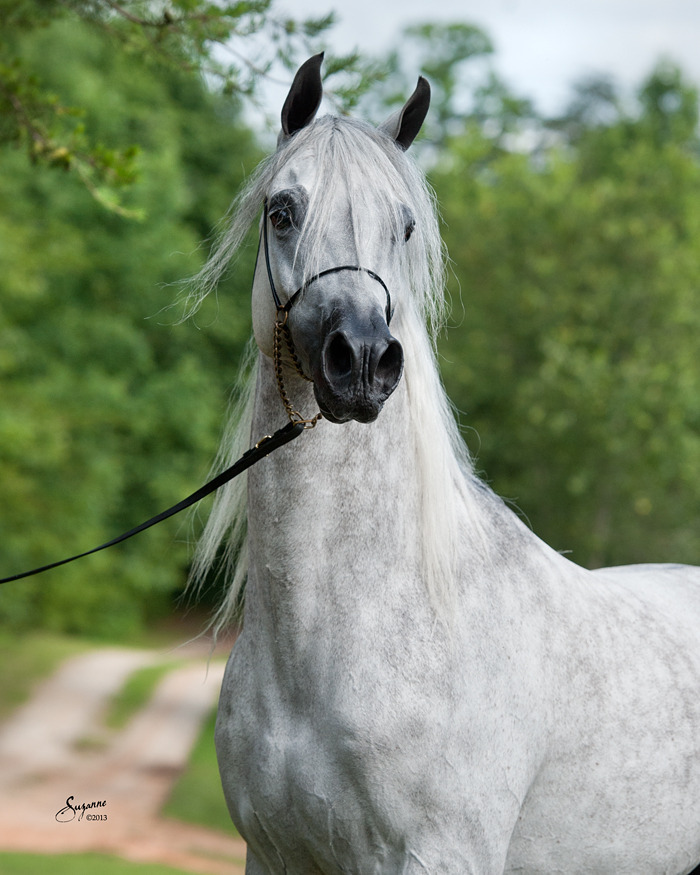

In [68]:
image = Image.open(fnames[0])
print('tamaño de la imagen: ', image.size)
image

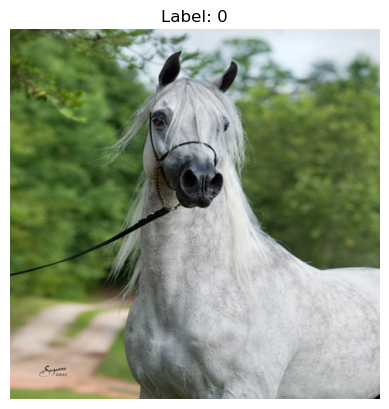

In [107]:
# Definir las transformaciones
transform = T.Compose([
    T.Resize((480,480)),
    T.ToTensor()
])

# Crear el dataset usando ImageFolder
dataset = ImageFolder(root=path, transform=transform)

# Obtener la primera imagen del dataset
image, label = dataset[0]

# Graficar la imagen
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [108]:
# Definir el tamaño del conjunto de validación
num_train = int(len(dataset)*0.8)  # 80% para entrenamiento
num_valid = len(dataset) - num_train  # 20% para validación

batch_size = 16

# Crear DataLoaders para entrenamiento y validación sin necesidad de samplers
#train_loader_hourses = DataLoader(train_dataset_hourses, batch_size=batch_size, shuffle=True)
#valid_loader_hourses = DataLoader(valid_dataset_hourses, batch_size=batch_size, shuffle=False)

train_loader_hourses = DataLoader(dataset, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(num_train)))
valid_loader_hourses = DataLoader(dataset, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(num_valid)))

len(train_loader_hourses) , len(valid_loader_hourses)

(13, 4)

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo preentrenado de Resnet34
resnet_model34 = torchvision.models.resnet34(pretrained=True)
resnet_model34.fc = nn.Linear(resnet_model34.fc.in_features , 3)
resnet_model34.to(device)
resnet_model34

c:\Users\hgarnica\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hgarnica\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Opcion 1

In [104]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   

In [109]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader_hourses):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, valid_loader_hourses)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [114]:
# Establecer el atributo requires_grad de todos los parámetros en el modelo en False.
for param in resnet_model34.parameters():
    param.requires_grad = False

# Establecer el atributo requires_grad de los parámetros de la ultima capa en el modelo en True.
for param in resnet_model34.fc.parameters():
    param.requires_grad = True


optimiser = torch.optim.Adam(resnet_model34.parameters(), lr=lr, betas=(0.9, 0.999))
epochs = 15

train(resnet_model34, optimiser, epochs)

Epoch: 0, costo: 0.682533323764801, accuracy: 0.6923076923076923,
Epoch: 1, costo: 0.199038565158844, accuracy: 0.9038461538461539,
Epoch: 2, costo: 0.4297376573085785, accuracy: 0.8076923076923077,
Epoch: 3, costo: 0.3738906681537628, accuracy: 0.8461538461538461,
Epoch: 4, costo: 0.225044384598732, accuracy: 0.5769230769230769,
Epoch: 5, costo: 0.055990636348724365, accuracy: 0.8846153846153846,
Epoch: 6, costo: 0.24789635837078094, accuracy: 0.8653846153846154,
Epoch: 7, costo: 0.059385668486356735, accuracy: 0.9807692307692307,
Epoch: 8, costo: 0.26919272541999817, accuracy: 0.9615384615384616,
Epoch: 9, costo: 0.6724000573158264, accuracy: 0.8653846153846154,
Epoch: 10, costo: 0.04314255714416504, accuracy: 0.8653846153846154,
Epoch: 11, costo: 0.30123573541641235, accuracy: 0.9423076923076923,
Epoch: 12, costo: 0.0798415020108223, accuracy: 0.9615384615384616,
Epoch: 13, costo: 0.08904500305652618, accuracy: 0.9038461538461539,
Epoch: 14, costo: 0.16615509986877441, accuracy: 0.9

In [116]:
accuracy(resnet_model34, valid_loader_hourses)

0.9423076923076923

In [166]:
resnet_model34(valid_loader_hourses.dataset[100][0].unsqueeze(0).to(device)).argmax(), valid_loader_hourses.dataset[100][1]

(tensor(1), 1)

## Opcion 2 

In [18]:
# Establecer el atributo requires_grad de todos los parámetros en el modelo en False.
for param in resnet_model34.parameters():
    param.requires_grad = False

# Establecer el atributo requires_grad de los parámetros de la ultima capa en el modelo en True.
for param in resnet_model34.fc.parameters():
    param.requires_grad = True

# Definir funciones de perdida y optimizador
loss_func_fc = torch.nn.CrossEntropyLoss()

# Solo le paso los parametros de la ultima capa al optimizador
optimizer = torch.optim.Adam(resnet_model34.parameters(), lr=0.01)

# Entrenar el modelo en pocas epocas (3)
for epoch in range(3):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader_hourses, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = resnet_model34(inputs)
        loss = loss_func_fc(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Guardar el modelo entrenado
torch.save(resnet_model34.state_dict(), "resnet_model34_fc_hourses.pth")

[1,    10] loss: 0.103
[2,    10] loss: 0.033
[3,    10] loss: 0.016


In [23]:
# Cargar el modelo guardado
resnet_model34.load_state_dict(torch.load("resnet_model34_fc_hourses.pth"))

<All keys matched successfully>

In [30]:
# Volver a establecer el atributo requires_grad de todos los parámetros en el modelo en True para entrenar el modelo completo.
for param in resnet_model34.parameters():
    param.requires_grad = True

lr = 0.01
n_epochs = 10

#calculo la cantidad de batches
n_batches_train = len(train_dataset_hourses) // batch_size
n_batches_valid = (len(valid_dataset_hourses) + batch_size - 1) // batch_size


loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model34.parameters(), lr=lr)

for idx_epoch in range(n_epochs):
    # Loop de entrenamiento
    loss_train_sum = 0
    n_batches_train = 0

    for x_train_batch, y_train_batch in train_loader_hourses:
        predictions = resnet_model34(x_train_batch)
        loss = loss_func(predictions, y_train_batch)
        loss_train_sum += loss.item()
        n_batches_train += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluamos los datos en validación
    loss_validation_sum = 0
    accuracy_sum = 0
    for x_valid_batch, y_valid_batch in valid_loader_hourses:
        predictions = resnet_model34(x_valid_batch)
        loss = loss_func(predictions, y_valid_batch)
        loss_validation_sum += loss.item()
        accuracy_sum += accuracy(predictions, y_valid_batch).item()
    
    # Imprimimos el loss en train y validación y la métrica (siempre en validación)
    accuracy_validation = accuracy_sum / n_batches_valid
    loss_validation = loss_validation_sum / n_batches_valid
    train_validation = loss_train_sum / n_batches_train
    print(f'epoch {idx_epoch} | train loss {loss_validation} | validation loss {train_validation} | accuracy {accuracy_validation}')

    # Guardar el modelo entrenado
torch.save(resnet_model34.state_dict(), "resnet_model34_hourses.pth")

epoch 0 | train loss 1.8931209743022919 | validation loss 1.3535451980737538 | accuracy 0.3020833358168602
epoch 1 | train loss 1.3387295007705688 | validation loss 1.1168305231974676 | accuracy 0.3177083358168602
epoch 2 | train loss 1.348990112543106 | validation loss 1.072224511550023 | accuracy 0.3958333358168602
epoch 3 | train loss 1.1481204479932785 | validation loss 1.0314905735162587 | accuracy 0.3958333358168602
epoch 4 | train loss 1.1676552891731262 | validation loss 0.8582580914864173 | accuracy 0.4739583358168602
epoch 5 | train loss 0.9872773587703705 | validation loss 0.8815127290212191 | accuracy 0.4114583358168602
epoch 6 | train loss 1.1382355391979218 | validation loss 0.8731330266365638 | accuracy 0.375
epoch 7 | train loss 1.149562031030655 | validation loss 1.0046082643362193 | accuracy 0.34375
epoch 8 | train loss 1.063525766134262 | validation loss 0.8653028240570655 | accuracy 0.4427083358168602
epoch 9 | train loss 1.1478219628334045 | validation loss 0.89911

In [57]:
predictions = resnet_model34(x_valid_batch)
predictions.argmax(dim=1)

tensor([2, 1, 0])